In this notebook we will estimate the periodicity component with different methods than the one used in AR.ipynb.

In [20]:
cd(@__DIR__)
include("table_reader.jl")
include("utils/utils.jl")

MAPE (generic function with 2 methods)

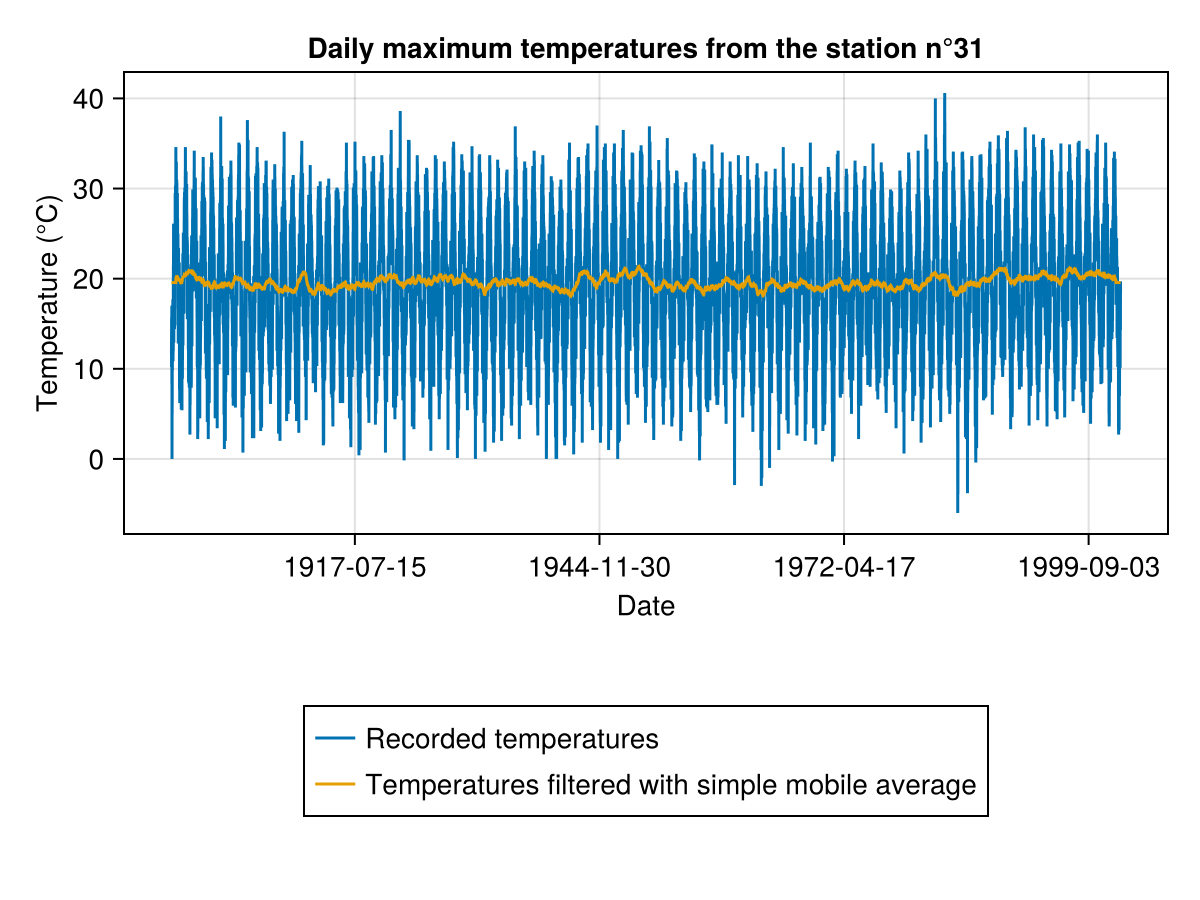

In [21]:
series,fig=extract_series("TX_STAID000031.txt",plot=true)
fig

## Drift

MSE estimators to estimate drift

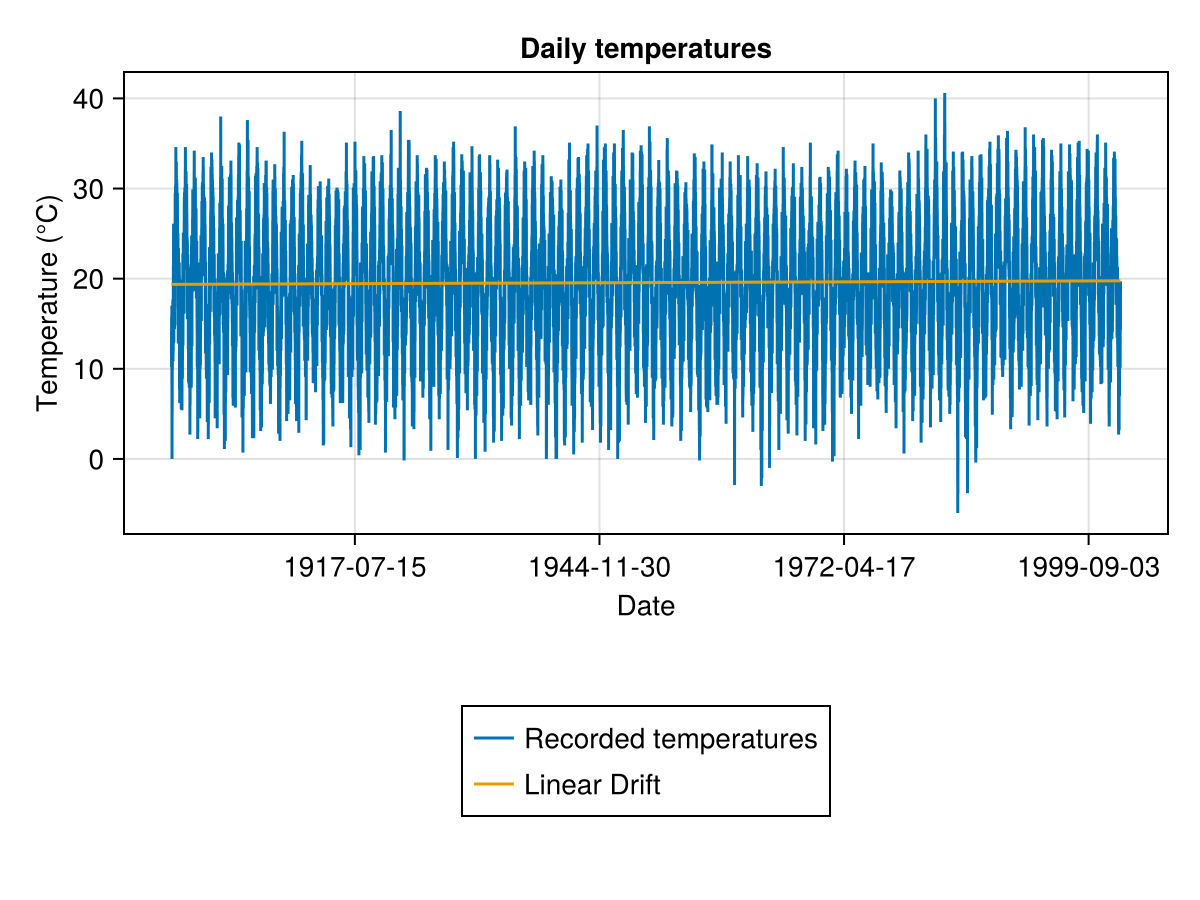

Intercept = 19.366009056392556
Slope = 1.0215034069842917e-5


In [22]:
N=size(series)[1]
X=cat(ones(N),1:N,dims=2)
beta=inv(transpose(X)*X)*transpose(X)*series[!,2]

fig=Figure()
ax, plot1=lines(fig[1:2, 1:2], series.DATE, series[!,2])
plot2=lines!(ax,series.DATE,X*beta)
ax.title="Daily temperatures"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
Legend(fig[3, 1:2],[plot1,plot2],["Recorded temperatures","Linear Drift"])
display(fig)

println("Intercept = $(beta[1])")
println("Slope = $(beta[2])")

We can see that the drift is (almost) only a constant. We can consider it in our periodicity component estimation, as the $\mu$ parameter.

# 1.Trigonometrical parametrical model

In this model the periodicity $S_t$ will follow this equation :  $S_t = \mu + a\cos(\frac{2πt}{365.25}) + b\sin(\frac{2πt}{365.25})$. $\mu$, $a$ and $b$ will be estimated by fitting this equation on our series with an OLS regression.

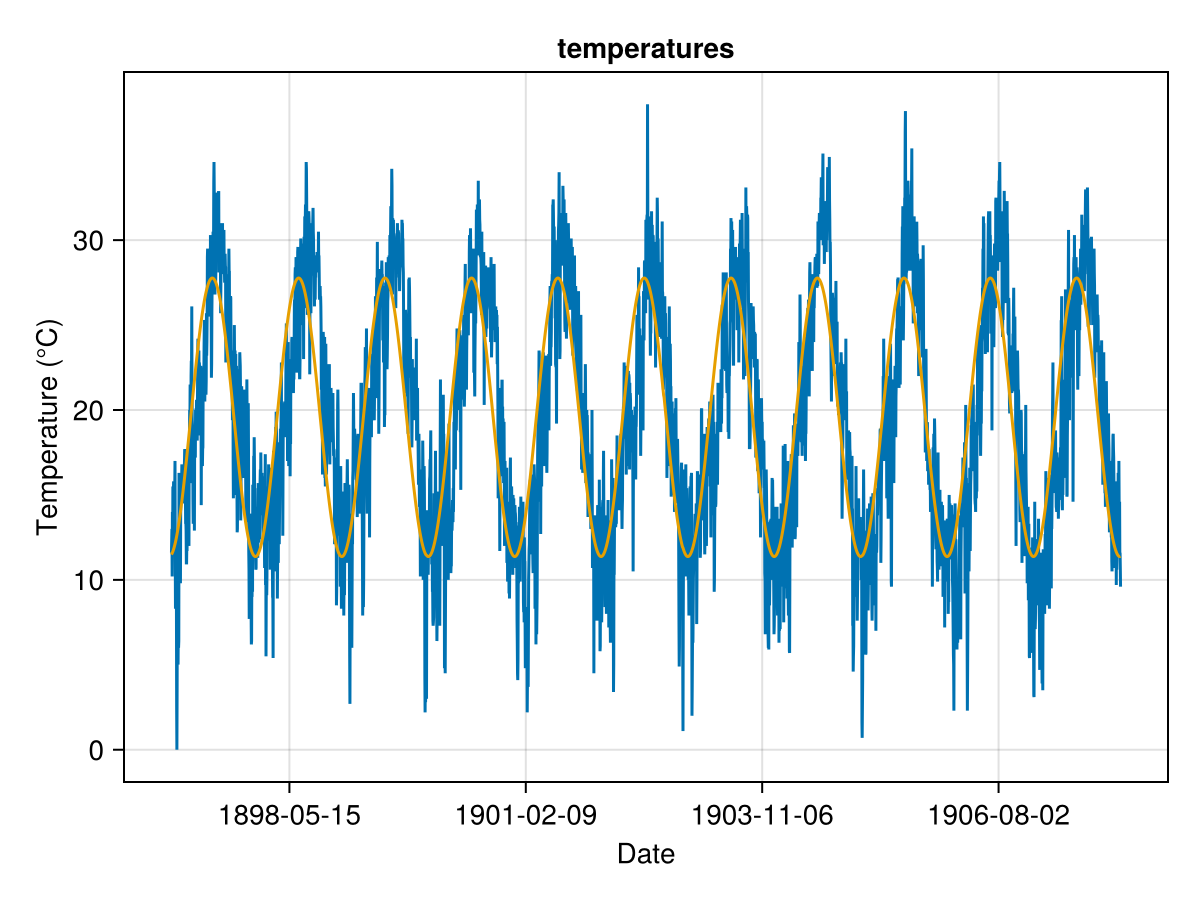

In [23]:
include("utils/periodicity.jl")
trigo_function=fitted_periodicity(series[!,2])
periodicity=trigo_function.(1:N)

Myyear=Iyear(series.DATE,year(series.DATE[1]):year(series.DATE[1]) + 10)
fig, ax = lines(series.DATE[Myyear],series[Myyear,2])
lines!(ax,series.DATE[Myyear],periodicity[Myyear])
ax.title="temperatures"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
current_figure()

It seems that there is a small shift between the periodicity and the real data.

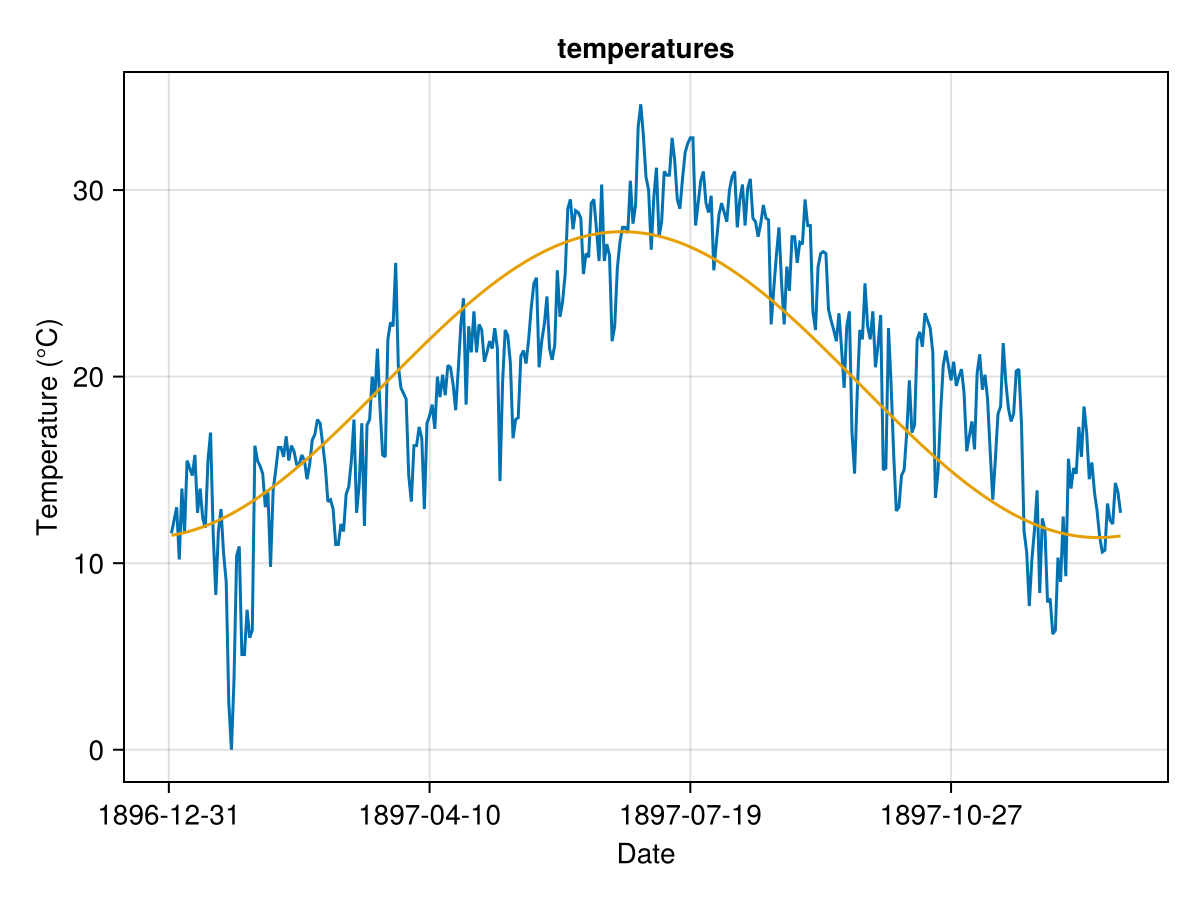

In [24]:
Myyear=Iyear(series.DATE,year(series.DATE[1]))
fig, ax = lines(series.DATE[Myyear],series[Myyear,2])
lines!(ax,series.DATE[Myyear],periodicity[Myyear])
ax.title="temperatures"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
current_figure()

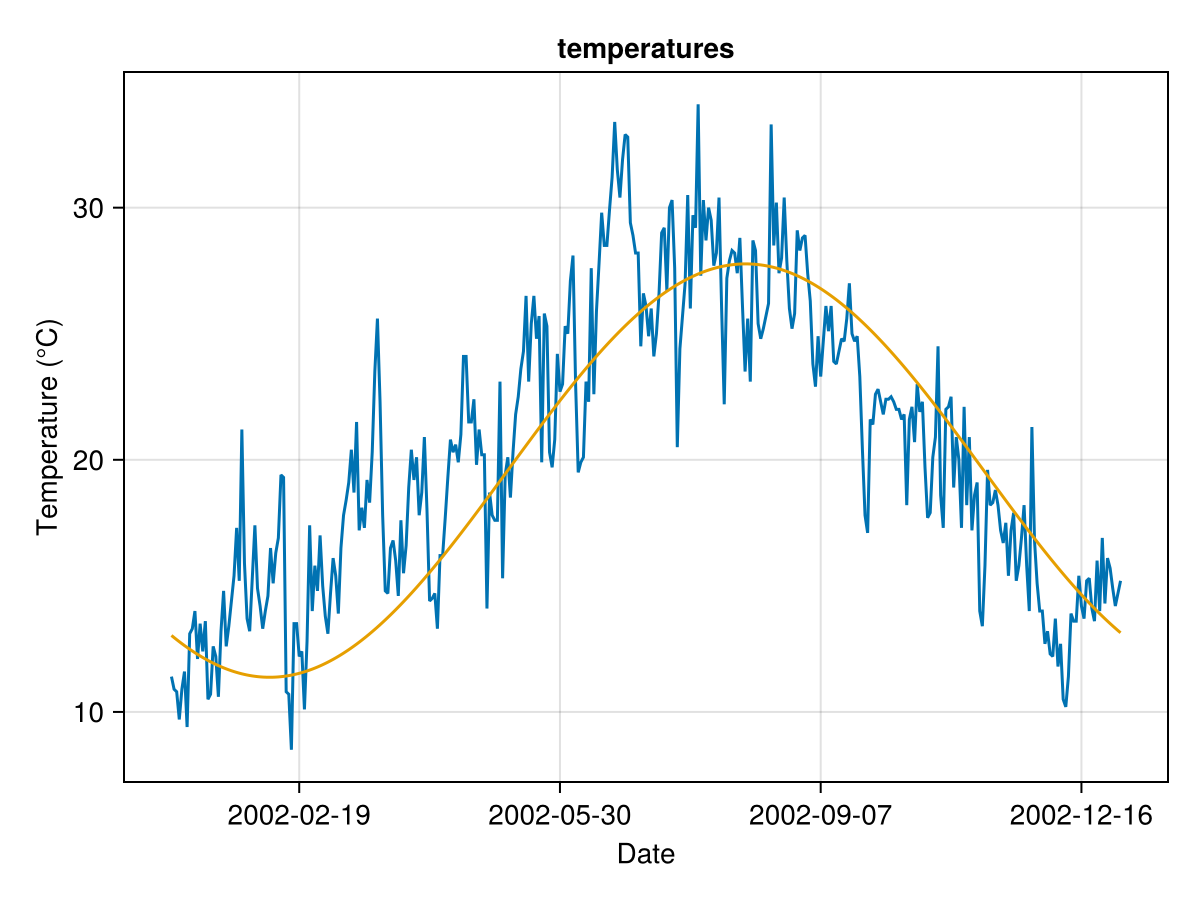

In [25]:
Myyear=Iyear(series.DATE,year(series.DATE[end])-1)
fig, ax = lines(series.DATE[Myyear],series[Myyear,2])
lines!(ax,series.DATE[Myyear],periodicity[Myyear])
ax.title="temperatures"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
current_figure()

This shift is more noticeable at the beginning and the end of the series.

We will work on the series without the periodicity : 

In [26]:
x=series[!,2]-periodicity

38758-element Vector{Float64}:
  0.10971201110036688
  0.7848436659985172
  1.4575912020049522
 -1.3720373160933441
  2.395966879633285
 -0.038386742337529256
  3.82491198421784
  3.385873920260533
  2.9445106182751335
  4.000834318850952
  ⋮
  4.971127867520968
  2.874942671826643
  1.3769977375571063
  0.4773220494307999
  2.3759451043478936
  5.172896902658719
  5.568207939286449
  4.0619091947034835
  4.6540321257606045

## Autocorrelations

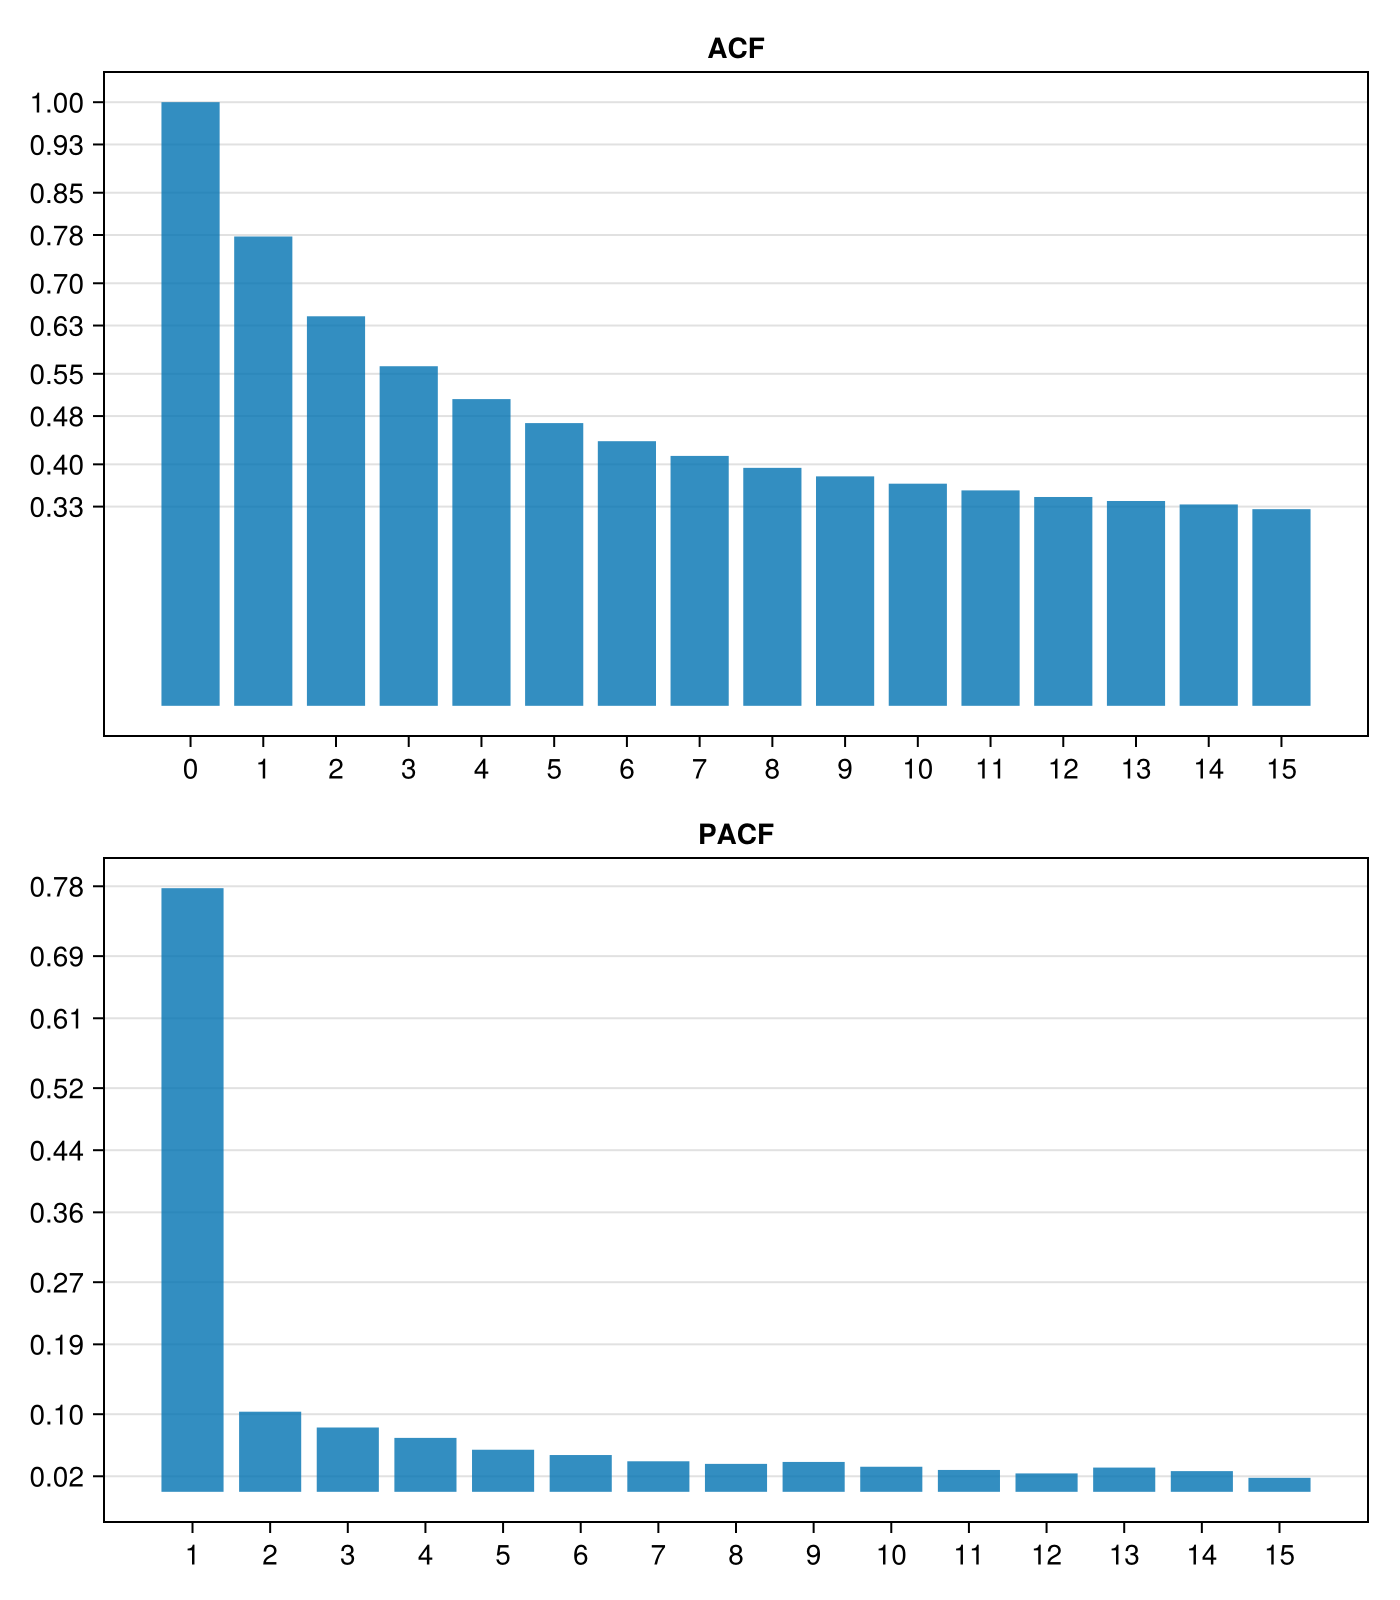

In [27]:
include("utils/ACF_PACF.jl")
ACF_PACF(x)

It still looks like an AR(1) model

## Estimation with Likelihood

In [28]:
include("utils/Estimation.jl")
p=1
Φ, σ=LL_AR_Estimation(x,p)

([0.7775234276407761], 2.244409207327579)

## Sampling simulations

In [29]:
include("utils/Simulation.jl")
sample_=invert(sample_simulation(x[1:p],Φ,σ,periodicity,10000))

365-element Vector{Vector{Float64}}:
 [11.6, 8.738512836916714, 9.217219897585421, 6.65613200745853, 14.729525708381681, 11.337160094951646, 9.871912550231327, 16.719285754179854, 13.980323030689883, 6.267444391754581  …  9.760559692216964, 8.407825918453671, 13.172388703875416, 6.187741249997147, 12.751260243391627, 12.986028259495214, 11.85188449348195, 8.198203517845554, 10.171214984233647, 9.786386701337417]
 [14.030396247115515, 7.509545168061447, 11.592836729284414, 6.770681391074151, 13.79018900764606, 10.446249452420318, 12.720396459698268, 10.932190040850042, 10.936984710539674, 10.50130407035117  …  12.064498808971567, 7.793288066292767, 14.884838166659243, 5.548863630321863, 8.863694708729456, 15.023924862064495, 11.725264252051938, 11.805086971731209, 14.7314600109743, 12.734706623057233]
 [16.87931046226104, 8.235496189508545, 11.007461807736785, 8.730264985788061, 12.194960495298304, 10.815526329400779, 14.331081922857123, 10.664257660348936, 10.002139990353582, 11.660452

To apply statistical functions on each days, the sample vector will be inverted (it was shaped like v[year][day], no it is shaped like v[day][year]).

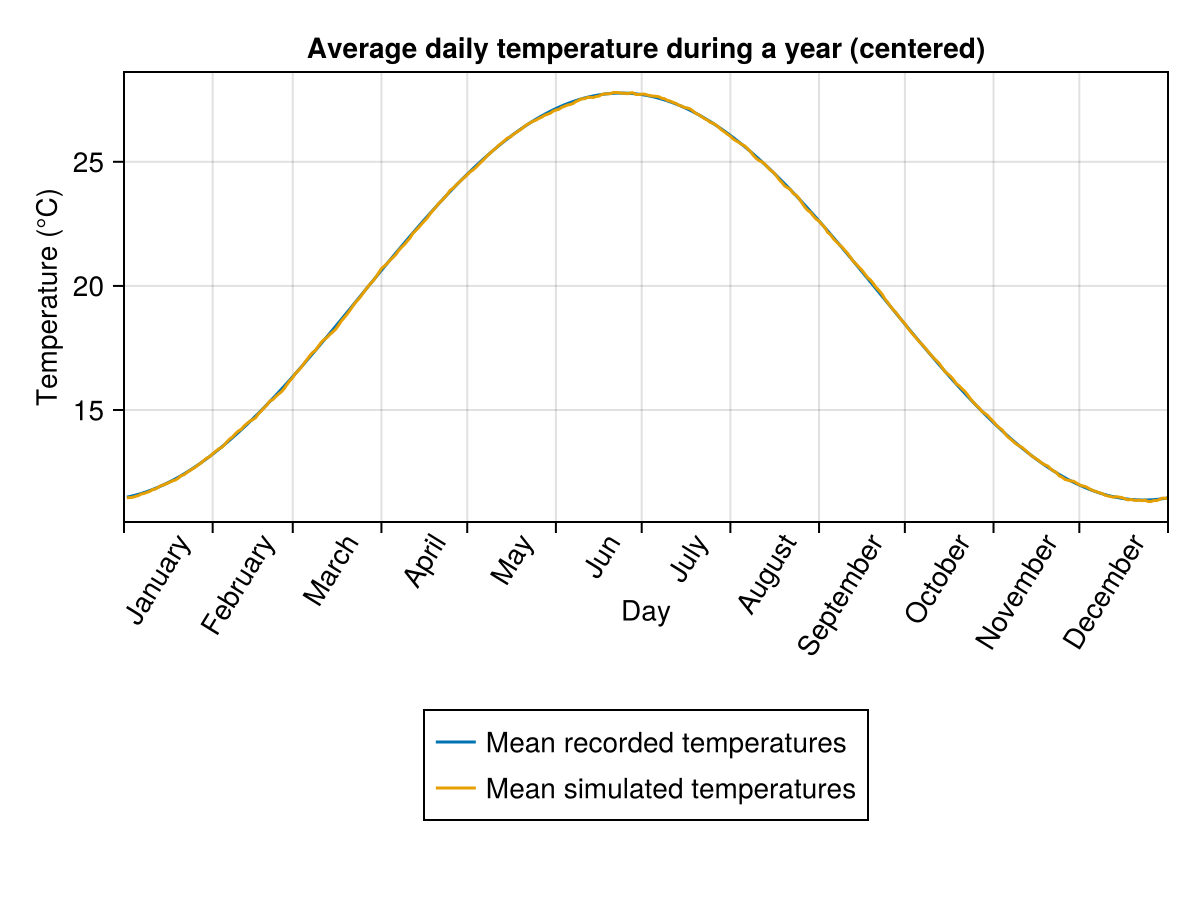

In [30]:
include("utils/Plotting.jl")
PlotYearCurves([periodicity[1:365],mean.(sample_)],["Mean recorded temperatures","Mean simulated temperatures"],"Average daily temperature during a year (centered)")

The generated sample seems to be unbiased.

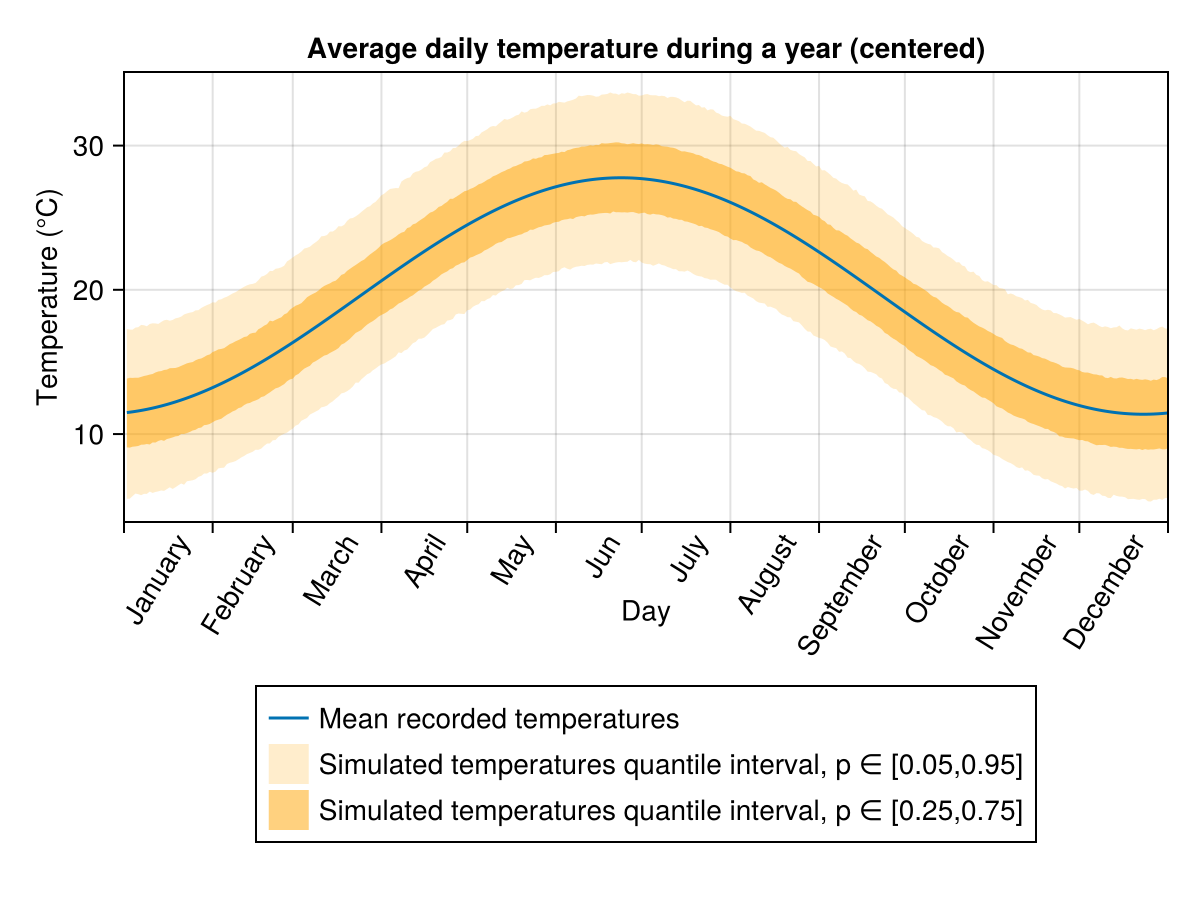

In [31]:
PlotYearCurves(periodicity[1:365],
["Mean recorded temperatures","Simulated temperatures quantile interval, p ∈ [0.05,0.95]","Simulated temperatures quantile interval, p ∈ [0.25,0.75]"],
"Average daily temperature during a year (centered)",
[(quantile.(sample_,0.05),quantile.(sample_,0.95)),(quantile.(sample_,0.25),quantile.(sample_,0.75))],
[("orange",0.2),("orange",0.5)]
)

# 2.Periodicity with regularization smoothing

In this model we use regularization smoothing on the average daily temperature to make our periodicity function. 
(see : https://docs.sciml.ai/DataInterpolations/stable/methods/)

In [32]:
include("utils/Periodicity.jl")
t_vec=n2t.(1:N,series.DATE[1])

38758-element Vector{Int64}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
  ⋮
 35
 36
 37
 38
 39
 40
 41
 42
 43

In [33]:
Days_list=[[] for _ in 1:366]
for (i,temp) in enumerate(series[!,2])
    push!(Days_list[n2t(i,series.DATE[1])],temp)
end
Days_list

366-element Vector{Vector{Any}}:
 [11.6, 11.3, 9.8, 17.8, 10.7, 9.8, 14.6, 10.8, 9.7, 15.0  …  10.3, 18.6, 13.0, 15.4, 18.5, 11.5, 9.8, 12.5, 13.5, 8.3]
 [12.3, 12.4, 15.2, 18.8, 7.6, 16.0, 15.5, 12.0, 9.7, 14.0  …  11.6, 12.2, 13.3, 14.6, 22.7, 15.5, 14.1, 13.9, 13.5, 10.1]
 [13.0, 15.7, 9.1, 13.8, 6.3, 17.6, 15.0, 12.7, 14.0, 11.2  …  14.7, 14.4, 12.2, 15.3, 16.9, 16.6, 15.3, 14.4, 12.2, 11.2]
 [10.2, 14.1, 11.8, 12.1, 4.5, 14.3, 14.7, 12.5, 16.5, 14.5  …  9.6, 17.4, 6.2, 19.0, 17.7, 17.6, 10.4, 13.3, 12.4, 10.5]
 [14.0, 13.9, 15.7, 12.8, 4.1, 12.3, 15.3, 14.3, 14.5, 14.3  …  15.4, 15.2, 8.0, 17.2, 17.6, 19.2, 13.4, 15.5, 10.1, 15.1]
 [11.6, 12.2, 15.4, 11.0, 5.3, 13.2, 16.1, 9.5, 8.1, 12.0  …  14.3, 11.3, 4.4, 17.0, 13.4, 15.2, 14.1, 16.7, 12.8, 14.0]
 [15.5, 12.4, 14.1, 11.0, 9.9, 13.5, 16.0, 7.9, 12.9, 12.1  …  12.6, 12.0, 10.2, 14.9, 14.3, 11.7, 13.7, 16.0, 17.4, 12.4]
 [15.1, 12.8, 14.3, 11.4, 9.8, 11.8, 16.3, 10.4, 9.5, 13.2  …  15.2, 16.1, 11.5, 13.2, 18.0, 9.4, 14.3, 11.1, 14

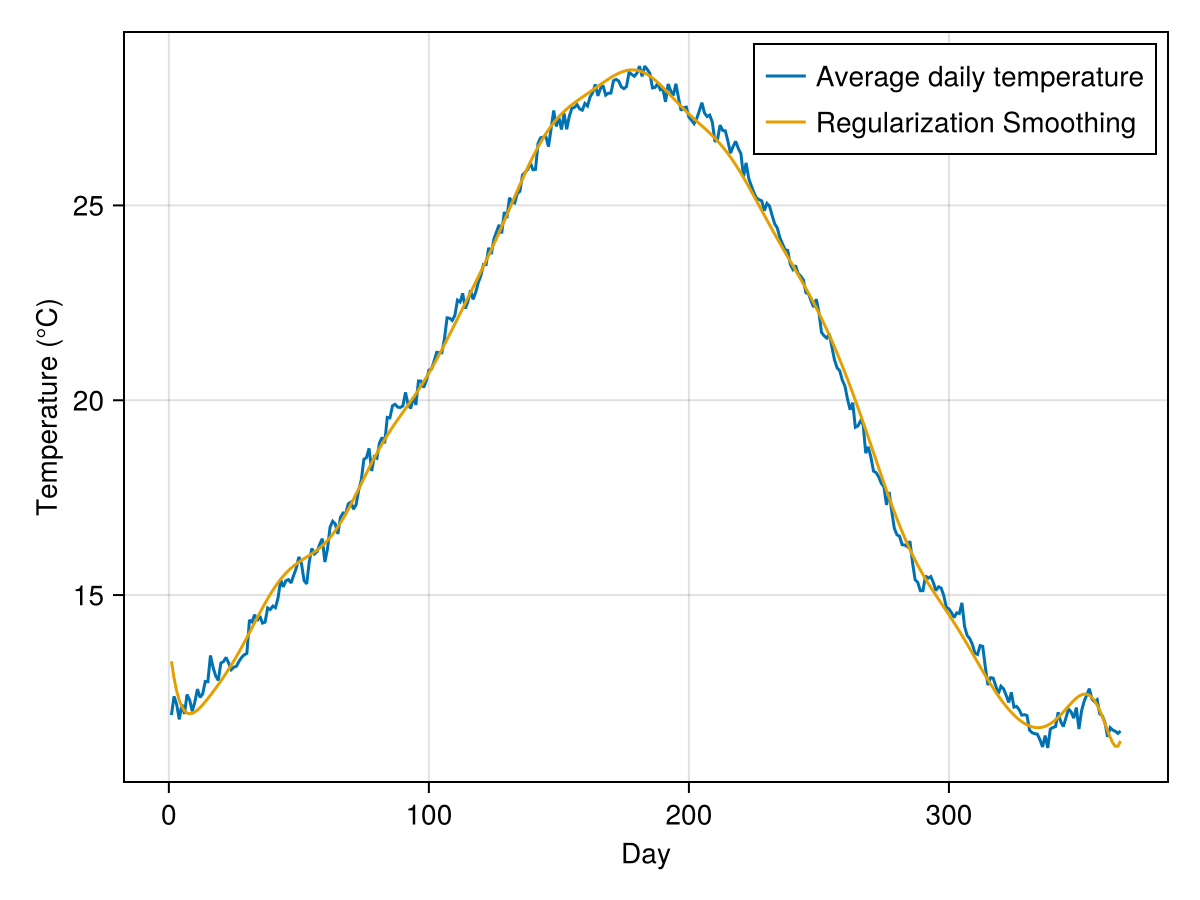

In [34]:
f=RegularizationSmooth(mean.(Days_list), 1:366, 9)
fig=Figure()
ax ,plt1= lines(fig[1:2,1:2],mean.(Days_list))
plt2=lines!(ax,f(1:366))
ax.xlabel="Day"
ax.ylabel="Temperature (°C)"
axislegend(ax,[plt1,plt2],["Average daily temperature","Regularization Smoothing"])
current_figure()

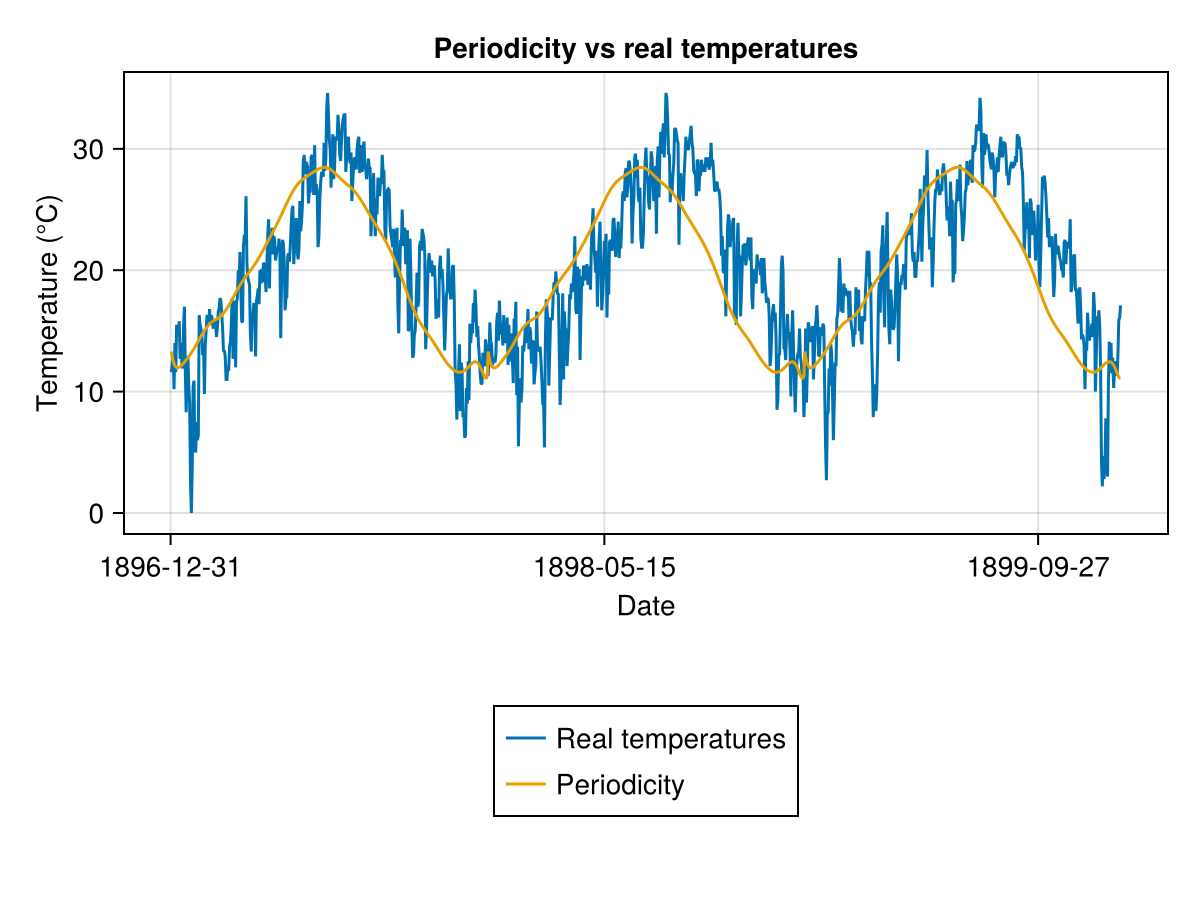

In [35]:
Smoothed_function(i)=f(n2t(i,series.DATE[1]))
periodicity=Smoothed_function.(1:N)

fig=Figure()
Myyear=Iyear(series.DATE,year(series.DATE[1]):year(series.DATE[1]) + 2)
ax ,plt1= lines(fig[1:2,1:2],series.DATE[Myyear],series[Myyear,2])
plt2=lines!(ax,series.DATE[Myyear],periodicity[Myyear])
ax.title="Periodicity vs real temperatures"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
Legend(fig[3,1:2],[plt1,plt2],["Real temperatures","Periodicity"])
current_figure()

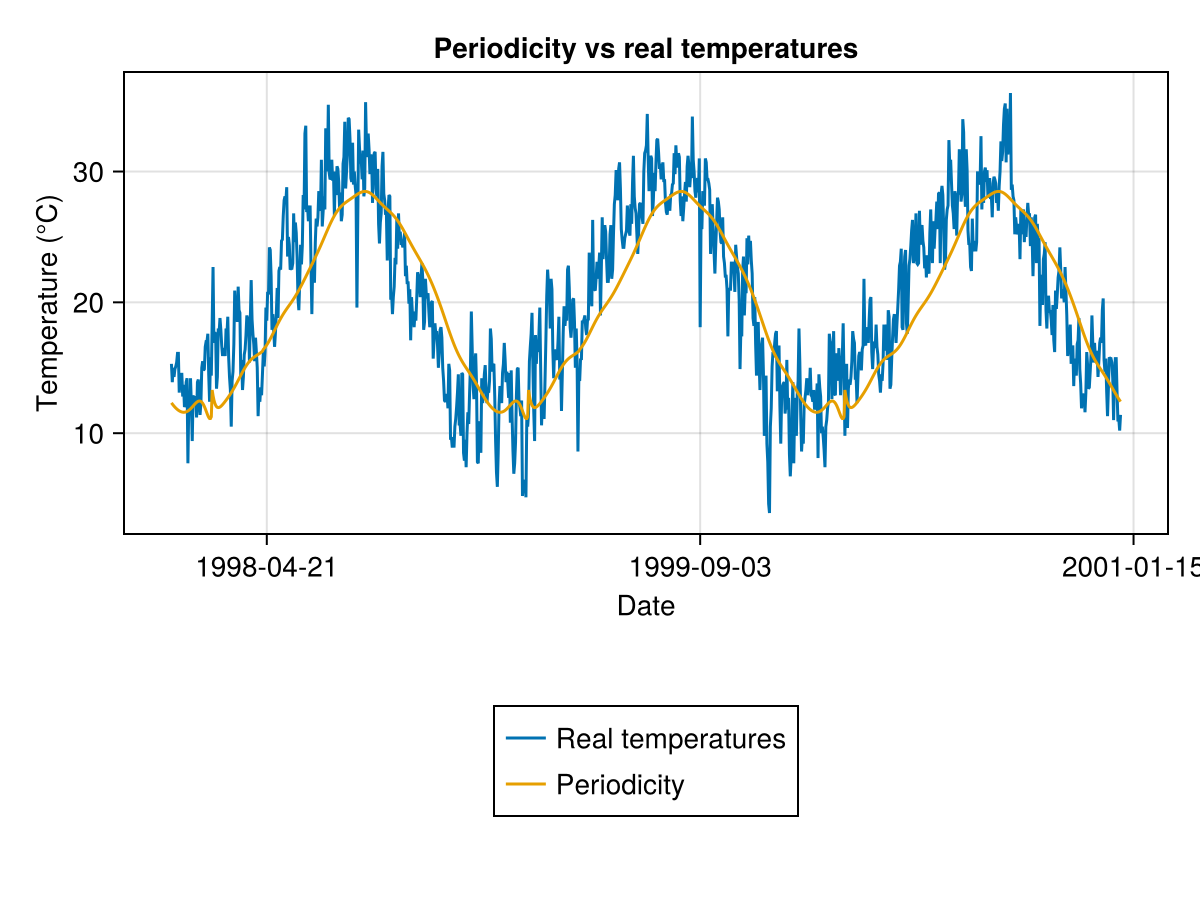

In [36]:
fig=Figure()
Myyear=Iyear(series.DATE,year(series.DATE[37000]):year(series.DATE[37000]) + 2)
ax ,plt1= lines(fig[1:2,1:2],series.DATE[Myyear],series[Myyear,2])
plt2=lines!(ax,series.DATE[Myyear],periodicity[Myyear])
ax.title="Periodicity vs real temperatures"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
Legend(fig[3,1:2],[plt1,plt2],["Real temperatures","Periodicity"])
current_figure()

1897-01-01
1897-12-31


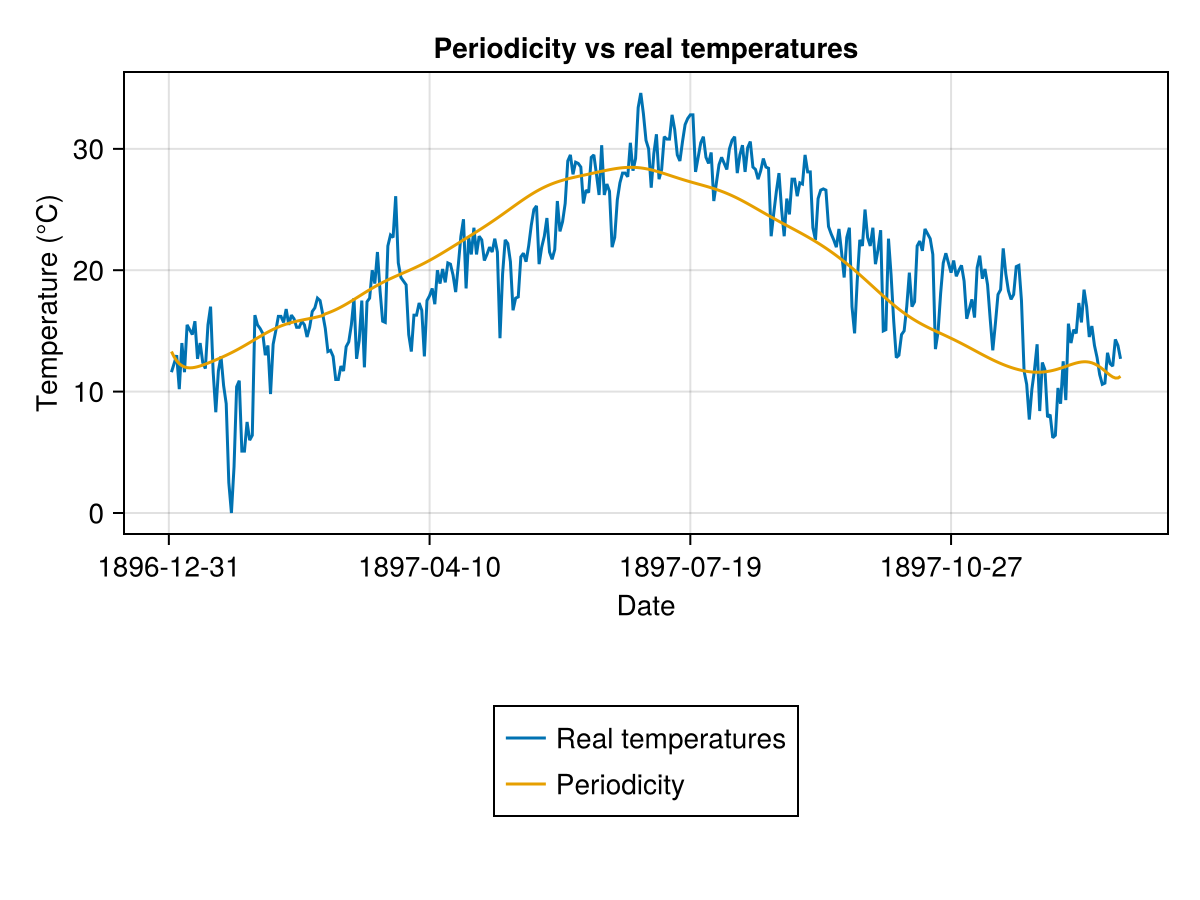

CairoMakie.Screen{IMAGE}


In [37]:
fig=Figure()
Myyear=Iyear(series.DATE,year(series.DATE[1]))
ax ,plt1= lines(fig[1:2,1:2],series.DATE[Myyear],series[Myyear,2])
plt2=lines!(ax,series.DATE[Myyear],periodicity[Myyear])
ax.title="Periodicity vs real temperatures"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
Legend(fig[3,1:2],[plt1,plt2],["Real temperatures","Periodicity"])
println(series.DATE[Myyear][1])
println(series.DATE[Myyear][end])
display(fig)

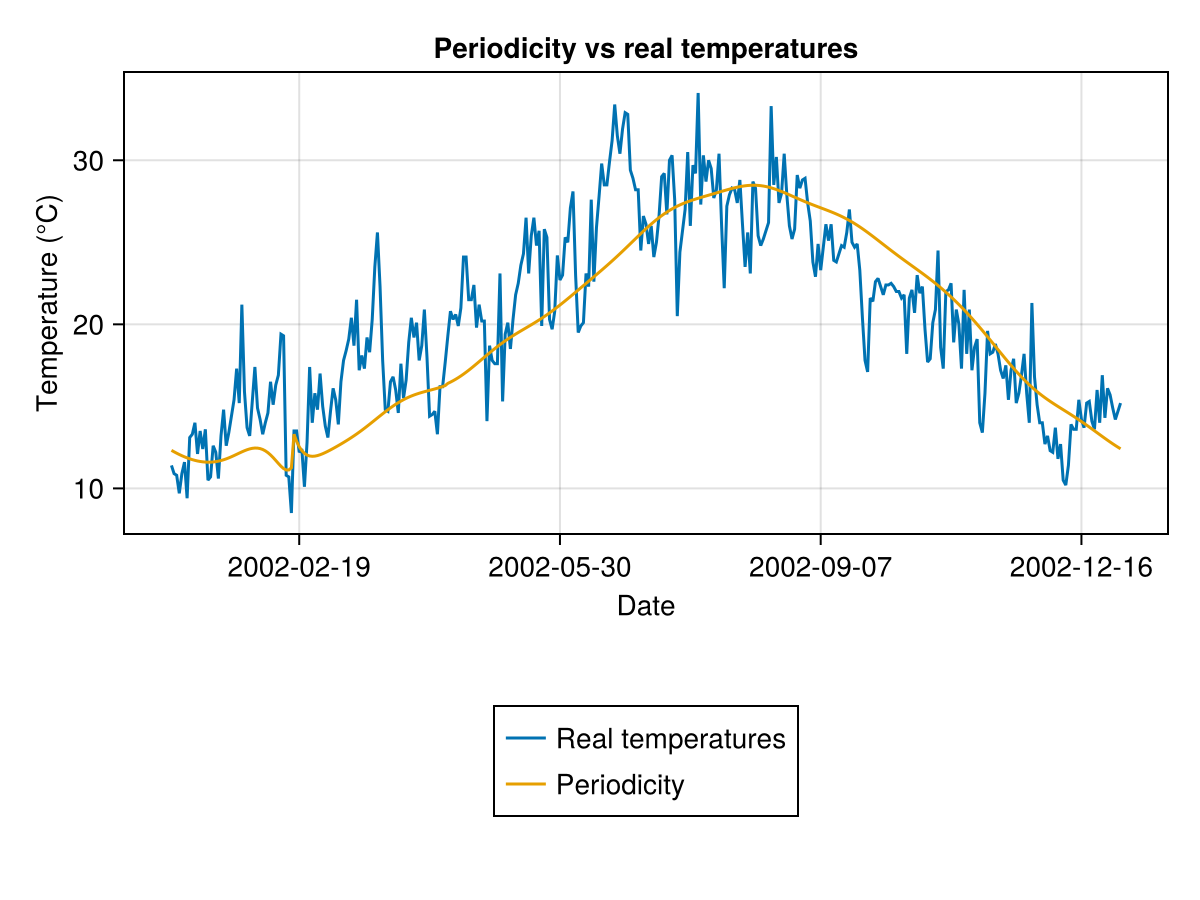

2002-01-01
2002-12-31


CairoMakie.Screen{IMAGE}


In [38]:
fig=Figure()
Myyear=Iyear(series.DATE,year(series.DATE[end])-1)
ax ,plt1= lines(fig[1:2,1:2],series.DATE[Myyear],series[Myyear,2])
plt2=lines!(ax,series.DATE[Myyear],periodicity[Myyear])
ax.title="Periodicity vs real temperatures"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
Legend(fig[3,1:2],[plt1,plt2],["Real temperatures","Periodicity"])
println(series.DATE[Myyear][1])
println(series.DATE[Myyear][end])
display(fig)

For this periodicity the shift is still present. The potential reason of this shift is the presence of missing values, that makes the original series shorter than it has to be.